In [1]:
!pip install -r rqts_gpu.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached PySimpleGUI-4.60.1-py3-none-any.whl (509 kB)
  Using cached sounddevice-0.4.4-py3-none-any.whl (31 kB)
  Using cached validators-0.19.0.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement torch==1.10.2+cu113 (from versions: 1.11.0)
ERROR: No matching distribution found for torch==1.10.2+cu113


Initialize 

In [4]:
import torch
from torch import nn

import torchaudio, torchvision
import matplotlib.pyplot as plt 
import librosa
import numpy as np
import wandb

from einops import rearrange
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from pytorch_lightning import LightningModule, Trainer, LightningDataModule, Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from torchmetrics.functional import accuracy
from torchvision.transforms import ToTensor
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.datasets.speechcommands import load_speechcommands_item

In [5]:

import os
CLASSES = ['silence', 'unknown', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
            'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no',
            'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
            'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


# make a dictionary from CLASSES to integers
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

if not os.path.exists(args.path):
    os.makedirs(args.path, exist_ok=True)

NameError: name 'args' is not defined

In [19]:
from argparse import ArgumentParser
def get_args():
    parser = ArgumentParser(description='PyTorch Transformer')
    parser.add_argument('--depth', type=int, default=12, help='depth')
    parser.add_argument('--embed_dim', type=int, default=64, help='embedding dimension')
    parser.add_argument('--num_heads', type=int, default=4, help='num_heads')



    parser.add_argument('--batch-size', type=int, default=3, metavar='N',
                        help='input batch size for training (default: 64)')


    parser.add_argument('--max-epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 30)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')
    parser.add_argument('--patch_num', type=int, default=4, help='patch_num')
    parser.add_argument('--kernel_size', type=int, default=3, help='kernel size')

    parser.add_argument('--accelerator', default='gpu', type=str, metavar='N')
    parser.add_argument('--devices', default=1, type=int, metavar='N')
    # parser.add_argument('--dataset', default='cifar10', type=str, metavar='N')
    parser.add_argument('--num_workers', default=4, type=int, metavar='N')


    # where dataset will be stored
    parser.add_argument("--path", type=str, default="data/speech_commands/")
    # 35 keywords + silence + unknown
    parser.add_argument("--num-classes", type=int, default=37)

    # mel spectrogram parameters
    parser.add_argument("--n-fft", type=int, default=1024)
    parser.add_argument("--n-mels", type=int, default=32)
    parser.add_argument("--win-length", type=int, default=None)
    parser.add_argument("--hop-length", type=int, default=512)
    # parser.add_argument("--hop-length", type=int, default=334)


    # 16-bit fp model to reduce the size
    parser.add_argument("--precision", default=16)
    # parser.add_argument("--accelerator", default='gpu')
    # parser.add_argument("--devices", default=1)
    # parser.add_argument("--num-workers", type=int, default=96)

    parser.add_argument("--no-wandb", default=True, action='store_true')

    
    args = parser.parse_args("")
    return args
args = get_args()

Lightning Data module basic


In [29]:

class SilenceDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(SilenceDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35
        path = os.path.join(self._path, torchaudio.datasets.speechcommands.EXCEPT_FOLDER)
        self.paths = [os.path.join(path, p) for p in os.listdir(path) if p.endswith('.wav')]

    def __getitem__(self, index):
        index = np.random.randint(0, len(self.paths))
        filepath = self.paths[index]
        waveform, sample_rate = torchaudio.load(filepath)
        return waveform, sample_rate, "silence", 0, 0

    def __len__(self):
        return self.len

class UnknownDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(UnknownDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35

    def __getitem__(self, index):
        index = np.random.randint(0, len(self._walker))
        fileid = self._walker[index]
        waveform, sample_rate, _, speaker_id, utterance_number = load_speechcommands_item(fileid, self._path)
        return waveform, sample_rate, "unknown", speaker_id, utterance_number

    def __len__(self):
        return self.len
        


In [ ]:

class KWSDataModule(LightningDataModule):
    def __init__(self, path, batch_size=128, num_workers=0, patch_num=4
                , n_fft=512, n_mels=128, win_length=None, hop_length=256
                , class_dict={}
                , **kwargs):

        print('_'*20, 'kws init')

        super().__init__(**kwargs)
        self.path = path

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.patch_num = patch_num

        # Window
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.class_dict = class_dict

    def prepare_data(self):
        print('_'*20, 'kws prep data')
        self.train_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                                download=True,
                                                                subset='training')

        silence_dataset = SilenceDataset(self.path)
        unknown_dataset = UnknownDataset(self.path)
        # self.train_dataset = torch.utils.data.ConcatDataset([self.train_dataset, silence_dataset, unknown_dataset])
        self.train_dataset = torch.utils.data.ConcatDataset([self.train_dataset, silence_dataset, unknown_dataset])

        self.train_set = torch.utils.data.ConcatDataset([self.train_dataset, silence_dataset, unknown_dataset])



        self.val_set = torchaudio.datasets.SPEECHCOMMANDS(self.path, download=True, subset='validation')
        self.val_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                              download=True,
                                                              subset='validation')

        self.test_set = torchaudio.datasets.SPEECHCOMMANDS(self.path, download=True, subset='testing')      
        self.test_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                               download=True,
                                                               subset='testing')     

        _, sample_rate, _, _, _ = self.train_dataset[0]
        self.sample_rate = sample_rate
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                              n_fft=self.n_fft,
                                                              win_length=self.win_length,
                                                              hop_length=self.hop_length,
                                                              n_mels=self.n_mels,
                                                              power=2.0)

    def setup(self, stage=None):
        print('_'*20, 'setup ')
        self.prepare_data()

    def train_dataloader(self):
        print('_'*20, 'kws train dataloader')
        return torch.utils.data.DataLoader( self.train_dataset,
                                            batch_size=self.batch_size,
                                            num_workers=self.num_workers,
                                            shuffle=True,
                                            pin_memory=True,
                                            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        print('_'*20, 'kws val dataloader')
        return torch.utils.data.DataLoader( self.val_dataset,
                                            batch_size=self.batch_size,
                                            num_workers=self.num_workers,
                                            shuffle=False,
                                            pin_memory=True,
                                            collate_fn=self.collate_fn
        )
    
    def test_dataloader(self):
        print('_'*20, 'kws test dataloader')
        return torch.utils.data.DataLoader( self.test_dataset,
                                            batch_size=self.batch_size,
                                            num_workers=self.num_workers,
                                            shuffle=True,
                                            pin_memory=True,
                                            collate_fn=self.collate_fn
        )




    def collate_fn(self, batch):
        mels = []
        xmels = []
        labels = []
        wavs = []
        for sample in batch:
            waveform, sample_rate, label, speaker_id, utterance_number = sample
            # ensure that all waveforms are 1sec in length; if not pad with zeros
            if waveform.shape[-1] < sample_rate:
                waveform = torch.cat([waveform, torch.zeros((1, sample_rate - waveform.shape[-1]))], dim=-1)
            elif waveform.shape[-1] > sample_rate:
                waveform = waveform[:,:sample_rate]

            # mel from power to db
            mel1 = ToTensor()(librosa.power_to_db(self.transform(waveform).squeeze().numpy(), ref=np.max))

            # print('mel1 shapre', mel1.shape)
            # mel1 = rearrange(mel1, 'c h w -> c h w', p1=self.patch_num, p2=self.patch_num)
            # print('mel1 shapre', mel1.shape)

            xmels.append(xmels)
            mels.append(mel1)
            labels.append(torch.tensor(self.class_dict[label]))
            wavs.append(waveform)

        mels = torch.stack(mels)
        labels = torch.stack(labels)
        wavs = torch.stack(wavs)

        # print('mels sh:', mels.shape)
        # x = rearrange(mels, 'b 1 h w -> b h w')
        x = mels
        x = rearrange(x, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=self.patch_num, p2=self.patch_num)
        # print('x sh:', x.shape)
        # return x, labels, wavs, sample_rate

        return x, labels



In [30]:

datamodule = KWSDataModule(batch_size=args.batch_size, num_workers=args.num_workers,
                        path=args.path, n_fft=args.n_fft, n_mels=args.n_mels,
                        win_length=args.win_length, hop_length=args.hop_length,
                        class_dict=CLASS_TO_IDX)
datamodule.prepare_data()
data = iter(datamodule.train_dataloader()).next()

____________________ kws init
____________________ kws prep data
____________________ kws train dataloader


In [31]:
data[0].shape

torch.Size([3, 16, 64])

In [91]:

# x = data[0][i]
# y = data[1][i]
# x.shape

torch.Size([64, 32])

In [77]:
# y.shape

torch.Size([])

In [79]:
# i = 0
# x = data[0][i]
# y = data[1][i]
# w = data[2][i]
# sample_rate = data[3]


IndexError: list index out of range

In [123]:
# print(args.hop_length)

512


In [144]:
# transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
#                                                               n_fft=args.n_fft,
#                                                               win_length=args.win_length,
#                                                               hop_length=334,
#                                                               n_mels=args.n_mels,
#                                                               power=2.0)
# mel1 = ToTensor()(librosa.power_to_db(transform(w).squeeze().numpy(), ref=np.max))
# mel1.shape

torch.Size([1, 64, 48])

In [98]:
# fs = sample_rate
# Time = np.linspace(0, len(w) / fs, num=len(w))

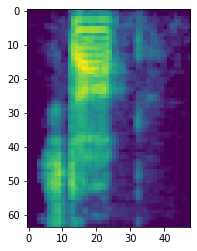

In [146]:
# from matplotlib import pyplot as plt
# fig = plt.figure
# # plt.figure(1)
# # plt.imshow(data[0][0][0]) # mels
# plt.imshow(mel1[0]) # mels

# # plt.plot(Time, w)
# plt.show()

PL LigtningMOdule MODEL

In [20]:

# # data = iter(datamodule.test_dataloader()).next()
# patch_dim = data[0].shape[-1]
# seqlen = data[0].shape[-2]
# print("Embed dim:", args.embed_dim)
# print("Patch size:", 32 // args.patch_num)
# print("Sequence length:", seqlen)

Embed dim: 64
Patch size: 8
Sequence length: 16


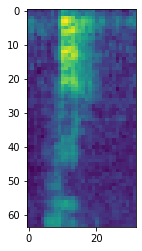

In [100]:
# from matplotlib import pyplot as plt
# fig = plt.figure
# # plt.imshow(data[0][0][0]) # mels
# plt.imshow(x) # mels
# # [1] = labels
# # [2] wav
# # plt.imshow(data[2][0])

to ewdit

In [32]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x

class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
      
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, 
            act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias) 
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer) 
   

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, dim, num_heads, num_blocks, mlp_ratio=4., qkv_bias=False,  
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, num_heads, mlp_ratio, qkv_bias, 
                                     act_layer, norm_layer) for _ in range(num_blocks)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


In [33]:
def init_weights_vit_timm(module: nn.Module):
    """ ViT weight initialization, original timm impl (for reproducibility) """
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()

In [34]:

        
class LitTransformer(LightningModule):
    def __init__(self, num_classes=10, lr=0.001, max_epochs=30, depth=12, embed_dim=64,
                 head=4, patch_dim=192, seqlen=16, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Transformer(dim=embed_dim, num_heads=head, num_blocks=depth, mlp_ratio=4.,
                                   qkv_bias=False, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
        self.embed = torch.nn.Linear(patch_dim, embed_dim)

        self.fc = nn.Linear(seqlen * embed_dim, num_classes)
        self.loss = torch.nn.CrossEntropyLoss()
        
        self.reset_parameters()


    def reset_parameters(self):
        init_weights_vit_timm(self)
    

    def forward(self, x):
        # Linear projection
        x = self.embed(x)
            
        # Encoder
        x = self.encoder(x)
        x = x.flatten(start_dim=1)

        # Classification head
        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        return loss
    

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        acc = accuracy(y_hat, y)
        return {"y_hat": y_hat, "test_loss": loss, "test_acc": acc}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc*100., on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self.test_epoch_end(outputs)



In [35]:
class WandbCallback(Callback):

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        # log 10 sample audio predictions from the first batch
        if batch_idx == 0:
            n = 10
            mels, labels, wavs = batch
            preds = outputs["preds"]
            preds = torch.argmax(preds, dim=1)

            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            wavs = torch.squeeze(wavs, dim=1)
            wavs = [ (wav.cpu().numpy()*32768.0).astype("int16") for wav in wavs]
            
            sample_rate = pl_module.hparams.sample_rate
            idx_to_class = pl_module.hparams.idx_to_class
            
            # log audio samples and predictions as a W&B Table
            columns = ['audio', 'mel', 'ground truth', 'prediction']
            data = [[wandb.Audio(wav, sample_rate=sample_rate), wandb.Image(mel), idx_to_class[label], idx_to_class[pred]] for wav, mel, label, pred in list(
                zip(wavs[:n], mels[:n], labels[:n], preds[:n]))]
            wandb_logger.log_table(
                key='ResNet18 on KWS using PyTorch Lightning',
                columns=columns,
                data=data)


Arguments and Other Stuff

In [39]:
datamodule = KWSDataModule(batch_size=args.batch_size, num_workers=args.num_workers,
                        path=args.path, n_fft=args.n_fft, n_mels=args.n_mels,
                        win_length=args.win_length, hop_length=args.hop_length,
                        class_dict=CLASS_TO_IDX)
datamodule.prepare_data()

data = iter(datamodule.train_dataloader()).next()
patch_dim = data[0].shape[-1]
seqlen = data[0].shape[-2]
print("Embed dim:", args.embed_dim)
print("Patch size:", 32 // args.patch_num)
print("Sequence length:", seqlen)


model = LitTransformer(num_classes=10, lr=args.lr, epochs=args.max_epochs, 
                        depth=args.depth, embed_dim=args.embed_dim, head=args.num_heads,
                        patch_dim=patch_dim, seqlen=seqlen,)
print(model)
trainer = Trainer(accelerator=args.accelerator, devices=args.devices,
                    max_epochs=args.max_epochs, precision=16 if args.accelerator == 'gpu' else 32,)

____________________ kws init
____________________ kws prep data
____________________ kws train dataloader


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Embed dim: 64
Patch size: 8
Sequence length: 16
LitTransformer(
  (encoder): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=False)
          (proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=64, out_features=256, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
      (1): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=False)
          (proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): M

In [42]:
trainer.fit(model, datamodule=datamodule)

____________________ kws prep data
____________________ setup 
____________________ kws prep data


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | Transformer      | 597 K 
1 | embed   | Linear           | 4.2 K 
2 | fc      | Linear           | 10.2 K
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
611 K     Trainable params
0         Non-trainable params
611 K     Total params
1.224     Total estimated model params size (MB)


____________________ kws val dataloader                            


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

main

In [41]:
CUDA_LAUNCH_BLOCKING=1


In [36]:
# def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
#     waveform = waveform.numpy()

#     num_channels, num_frames = waveform.shape
#     time_axis = torch.arange(0, num_frames) / sample_rate

#     figure, axes = plt.subplots(num_channels, 1)
#     if num_channels == 1:
#         axes = [axes]
#     for c in range(num_channels):
#         axes[c].plot(time_axis, waveform[c], linewidth=1)
#         axes[c].grid(True)
#         if num_channels > 1:
#             axes[c].set_ylabel(f'Channel {c+1}')
#         if xlim:
#             axes[c].set_xlim(xlim)
#         if ylim:
#             axes[c].set_ylim(ylim)
#     figure.suptitle(title)
#     plt.show(block=False)

# plot_waveform()